In [580]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [581]:
configs = [
    "Surrogate_Data_V5",
    "Surrogate_GBoost_V1",
    "Surrogate_KNN_V1",
    "Surrogate_LogReg_V1",
    "Surrogate_NaiveBayes_V1",
    "Surrogate_SVM_V1",
]

target_names = [
    "2024-04-28_07-18-23_lightcoral-pretty",
    "2024-04-28_22-59-40_blueviolet-physical",
    "2024-05-15_22-43-02_lightseagreen-first",
    "2024-05-15_06-47-54_mediumpurple-nothing",
    "2024-05-14_22-20-02_lightpink-medical",
    "2024-05-15_14-55-23_red-resource",
    "2024-04-10_13-36-12_darkcyan-why",
    "2024-04-29_15-29-39_darkkhaki-quickly",
    "2024-04-29_07-05-06_darkslategray-approach",
    "2024-04-28_15-07-53_aliceblue-suddenly",
    "2024-05-20_21-11-36_linen-civil",
    "2024-04-08_10-49-51_paleturquoise-nor",
    "2024-05-20_12-27-17_plum-television",
    "2024-05-21_13-37-58_mediumvioletred-worker",
    "2024-05-21_04-59-27_peachpuff-perform",
    "2024-05-21_21-37-36_seagreen-together",
    "2024-05-22_22-04-52_papayawhip-heavy",
    "2024-05-23_21-59-14_palegreen-local",
    "2024-05-23_06-06-40_darkslateblue-they",
    "2024-05-22_05-37-59_darkviolet-but",
    "2024-05-22_13-56-59_darkblue-until",
    "2024-05-23_14-03-55_peru-civil",
    "2024-05-24_21-29-40_chocolate-yourself",
    "2024-05-24_08-27-38_lightskyblue-might",
    "2024-05-24_06-02-52_cadetblue-lay",
    "2024-05-24_19-15-34_olive-simple",
    "2024-05-25_05-33-38_darkslateblue-even",
    "2024-05-24_10-34-12_darkmagenta-data",
    "2024-05-25_16-01-13_honeydew-million",
    "2024-05-26_00-32-57_mediumvioletred-open",
    "2024-05-26_08-50-46_darkmagenta-price",
    "2024-05-27_00-49-34_aqua-gas",
    "2024-05-26_16-57-36_mediumslateblue-agency",
    "2024-05-25_07-38-08_thistle-station",
    "2024-05-27_09-13-03_seashell-believe",
    "2024-05-27_12-31-57_darkorchid-involve",
    "2024-05-27_18-35-07_beige-indicate",
    "2024-05-27_21-38-23_papayawhip-sound",
    "2024-05-28_00-47-49_mediumblue-phone",
    "2024-05-27_15-25-51_peachpuff-from",
]

ignore = [
    "2024-04-29_07-05-06_darkslategray-approach",
    "2024-05-15_14-55-23_red-resource",
    "2024-05-15_06-47-54_mediumpurple-nothing",
    "2024-05-15_22-43-02_lightseagreen-first",
]

In [582]:
# def find_config(workspace):
#     with open(f"/app/wafcraft/data/prepared/{workspace}/config.txt", "r") as f:
#         config = f.read()
#     # parse the NAME: (format is NAME: Surrogate_Data_V3)
#     name = config.split("NAME: ")[1].split("\n")[0]
#     return name
def find_workspaces(config):
    prepared_dir = "/app/wafcraft/data/prepared"
    this_results_dir = "/app/wafcraft/results/architecture_experiments"
    workspace_names_with_targetunderscore = os.listdir(this_results_dir)
    # split the target names from the workspace names at the first underscore
    workspace_names = [name.split("_", 1)[1] for name in workspace_names_with_targetunderscore]
    search_str = f": {config}\n"
    matching_workspaces = []
    for workspace in workspace_names:
        with open(f"{prepared_dir}/{workspace}/config.txt", "r") as f:
            config = f.read()
        if search_str in config:
            matching_workspaces.append(workspace)
    return matching_workspaces

def get_transferabilities(target):
    transferabilities = {}
    data = pd.read_csv(f"/app/wafcraft/results/architecture_experiments/target_{target}/transferability.csv")
    for index, row in data.iterrows():
        if row["surrogate_workspace"] not in ignore:
            if row["config"] not in transferabilities:
                transferabilities[row["config"]] = []
            transferabilities[row["config"]].append(row["samples_evaded_percentage"])
    return transferabilities

def mean_transferabilities_single_target(transferabilities):
    means = {}
    for config, values in transferabilities.items():
        means[config] = sum(values) / len(values)
    return means

In [583]:
# create a dictionary of workspaces for each config
workspaces = {}
for config in configs:
    this_workspaces = find_workspaces(config)
    this_workspaces = [w for w in this_workspaces if w not in ignore] # remove the ignored workspaces
    workspaces[config] = this_workspaces

In [584]:
# Create a dictionary of transferabilities for each target
# means_per_target will look like this:
# {
#     "Surrogate_Data_V5": {
#         "Surrogate_Data_V5": 0.9167245153079279,
#         "Surrogate_SVM_V1": 0.47909912998232085,
#         "Surrogate_GBoost_V1": 0.5867911914243019,
#         "Surrogate_NaiveBayes_V1": 0.349217340248029,
#         "Surrogate_LogReg_V1": 0.42137737341797754,
#         "Surrogate_KNN_V1": 0.31808236561329783,
#     },
#     "Surrogate_GBoost_V1": {
#         "Surrogate_Data_V5": 0.7089505536035176,
#         "Surrogate_SVM_V1": 0.6619962302807056,
#         ...
#     },
#     ...
# }

means_per_target = {}

for target_config in configs:
    target_workspaces = find_workspaces(target_config)
    target_workspaces = [
        w for w in target_workspaces if w not in ignore
    ]  # remove the ignored workspaces

    all_means_of_this_target_conf = {}
    all_means_of_this_target_conf_mean = {}
    for target in target_workspaces:
        transferabilities = get_transferabilities(target)
        means = mean_transferabilities_single_target(transferabilities)
        for surrogate_config, mean in means.items():
            if surrogate_config not in all_means_of_this_target_conf:
                all_means_of_this_target_conf[surrogate_config] = []
            all_means_of_this_target_conf[surrogate_config].append(mean)
    for surrogate_config, means in all_means_of_this_target_conf.items():
        all_means_of_this_target_conf_mean[surrogate_config] = sum(means) / len(means)

    means_per_target[target_config] = all_means_of_this_target_conf_mean

print(means_per_target)

{'Surrogate_Data_V5': {'Surrogate_Data_V5': 0.9167245153079279, 'Surrogate_SVM_V1': 0.47909912998232085, 'Surrogate_GBoost_V1': 0.5867911914243019, 'Surrogate_NaiveBayes_V1': 0.349217340248029, 'Surrogate_LogReg_V1': 0.42137737341797754, 'Surrogate_KNN_V1': 0.31808236561329783}, 'Surrogate_GBoost_V1': {'Surrogate_Data_V5': 0.7089505536035176, 'Surrogate_SVM_V1': 0.6619962302807056, 'Surrogate_GBoost_V1': 0.9347691426120449, 'Surrogate_NaiveBayes_V1': 0.4270922335172164, 'Surrogate_LogReg_V1': 0.6201348427940393, 'Surrogate_KNN_V1': 0.3281451144927046}, 'Surrogate_KNN_V1': {'Surrogate_Data_V5': 0.7553063166799622, 'Surrogate_SVM_V1': 0.6433706364075108, 'Surrogate_GBoost_V1': 0.6610483112293911, 'Surrogate_NaiveBayes_V1': 0.37480556072901594, 'Surrogate_LogReg_V1': 0.5369120605909697, 'Surrogate_KNN_V1': 0.7330254386515533}, 'Surrogate_LogReg_V1': {'Surrogate_Data_V5': 0.7417626031045446, 'Surrogate_SVM_V1': 0.6739997110538791, 'Surrogate_GBoost_V1': 0.8577778925458821, 'Surrogate_Naive

In [585]:
# Create a heatmap of transferabilities
# Convert the entries from 0.123 to percentages
for target_config, transferabilities in means_per_target.items():
    for surrogate_config, mean in transferabilities.items():
        means_per_target[target_config][surrogate_config] = mean * 100

config_names = {
    "Surrogate_Data_V5": "RF",
    "Surrogate_GBoost_V1": "GBoost",
    "Surrogate_KNN_V1": "KNN",
    "Surrogate_LogReg_V1": "LogReg",
    "Surrogate_NaiveBayes_V1": "NaiveBayes",
    "Surrogate_SVM_V1": "SVM",
}

df = pd.DataFrame(means_per_target)

df.rename(index=config_names, columns=config_names, inplace=True)

order = ["RF", "SVM", "GBoost", "KNN", "LogReg", "NaiveBayes"]
df = df.loc[order, order]
df = df.T

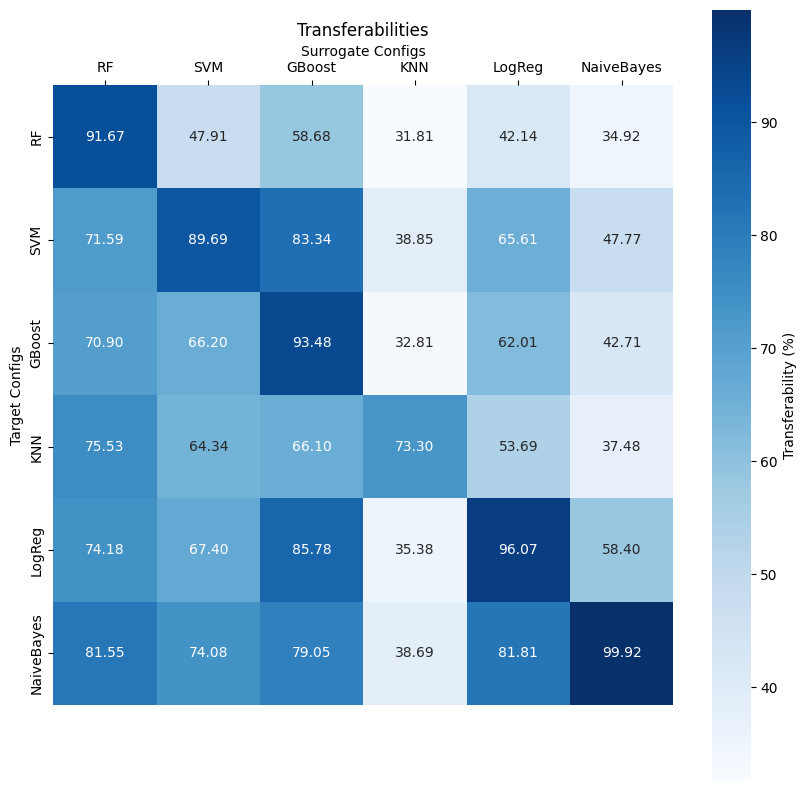

In [586]:
# Create a heatmap
plt.figure(figsize=(10, 10))
plt.title("Heatmap of Transferability Scores")


ax = sns.heatmap(
    df,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={"label": "Transferability (%)"},
    square=True,
)

ax.set_xlabel("Surrogate Configs")
ax.set_ylabel("Target Configs")

ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")

plt.show()

In [587]:
# Calculate the average transferability for each target config

print("Average transferability for each target config (the lower, the \"safer\" the architecture):")
print(df.mean(axis=1).sort_values(ascending=True))

print("Average transferability for each surrogate config (the higher, the \"better\" for attacker):")
print(df.mean(axis=0).sort_values(ascending=False))

Average transferability for each target config (the lower, the "safer" the architecture):
RF            51.188199
GBoost        61.351469
KNN           61.741139
SVM           66.144400
LogReg        69.534323
NaiveBayes    75.850005
dtype: float64
Average transferability for each surrogate config (the higher, the "better" for attacker):
GBoost        77.738638
RF            77.570438
SVM           68.270626
LogReg        66.888437
NaiveBayes    53.534401
KNN           41.806994
dtype: float64
